# **Notebook to make predictions with reprocessed Yoneda and Henson data and EFLUX2 and SPOT** 

### **Import python packages**

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import cobra
from statistics import mean, median
%matplotlib inline
from matplotlib import pyplot as plt
from edd_utils import login, export_study, export_metadata

### **Import Joonhoons Code**

In [2]:
# OptlangDir = '../EFLUX2_SPOT'
# sys.path.append(OptlangDir)
# from spot_cplex import SPOT #spot not working yet because quadratic constraints not supported yet

### **Sign into EDD**

In [5]:
study_slug = 'biodesign_henson2018_reprocessed'
edd_server = 'public-edd.jbei.org'
user = 'garrettroell' # 'schenkch'
session = login(edd_server=edd_server, user=user)

Password for garrettroell:  ················


### **Get transcriptomic data from [EDD](https://public-edd.jbei.org/s/biodesign_henson2018_reprocessed/)**

In [6]:
df = export_study(session, study_slug, edd_server=edd_server)
trans_df = df[df['Protocol'].str.contains('Transcriptomics')]
trans_df.head()

,Study ID,Study Name,Line ID,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,Measurement Type,Compartment,Units,Value,Hours
0,14409,Biodesign_Henson2018_reprocessed,14905,WT-M-R1,R. Opacus wild type strain with Mixture of all...,Transcriptomics,14948,WT-M-R1,NaN,WP_000104864_1,0,FPKM,0.0,20.0
1,14409,Biodesign_Henson2018_reprocessed,14905,WT-M-R1,R. Opacus wild type strain with Mixture of all...,Transcriptomics,14948,WT-M-R1,NaN,WP_000104864_1,0,FPKM,0.0,32.0
2,14409,Biodesign_Henson2018_reprocessed,14906,WT-M-R2,R. Opacus wild type strain with Mixture of all...,Transcriptomics,14949,WT-M-R2,NaN,WP_000104864_1,0,FPKM,0.0,20.0
3,14409,Biodesign_Henson2018_reprocessed,14906,WT-M-R2,R. Opacus wild type strain with Mixture of all...,Transcriptomics,14949,WT-M-R2,NaN,WP_000104864_1,0,FPKM,0.0,32.0
4,14409,Biodesign_Henson2018_reprocessed,14907,WT-M-R3,R. Opacus wild type strain with Mixture of all...,Transcriptomics,14950,WT-M-R3,NaN,WP_000104864_1,0,FPKM,0.0,20.0


### **Load Genome Scale Model**

In [7]:
file_name =  '../GSMs/Ropacus_annotated_curated_with_phenol_custom_biomass.xml'
model = cobra.io.read_sbml_model(file_name)

### **Define functions used in main EFlux function**

Define function to plot histogram from list of numbers. Will be used for transcriptomic measurements and flux bounds

In [8]:
def plot_histogram(data, title):

    bins = np.arange(0, 400, 5) # x axis goes from 0 to 40 with bars of width 5
    plt.hist(data, bins=bins, alpha=0.5) 
    plt.title(f'{title}\nmean = {mean(data):.3f}, median={median(data):.3f} max={max(data):.3f}')
    plt.xlabel('Transcriptomics value')
    plt.ylabel('count')
    plt.show()

Define a function to find the transcriptomic value for a given reaction id. The function takes into account genes that are required in parallel and in series.

In [9]:
def rxn_id_to_upper_bound(model, trans_df, rxn_id):
    associated_genes = model.reactions.get_by_id(rxn_id).gene_reaction_rule
    parallel_transcript_values = []
    
    if associated_genes:
        for parallel_gene_string in associated_genes.split(' or '):
            parallel_gene_string = parallel_gene_string.strip('() ')
            
            series_transcript_values = []
            for gene_name in parallel_gene_string.split(' and '):
                gene_name = gene_name.strip('() ')
                if gene_name == 'spontaneous':
                    series_transcript_values.append(np.Inf) # A spontaneous reaction should not require transcripts
                else:
                    transcript_value = float(trans_df[trans_df['Measurement Type'] == gene_name].Value)
                    series_transcript_values.append(transcript_value)
            
            parallel_transcript_values.append(min(series_transcript_values))
            
        return sum(parallel_transcript_values)
    else:
        return np.Inf # Reactions without transcript measurements shouldn't be constrained

### **Main EFlux function**

In [14]:
from optlang.symbolics import add

def EFlux2test(model, edd_df, line_name, min_bound = 10):
    
    # get transcriptomics measurement for a single experiment and plot values
    trans_df = edd_df[edd_df['Line Name'] == line_name]
    plot_histogram(trans_df['Value'], 'Transcriptomic values by genes')
    
    # make a dataframe mapping reaction to transcript levels using cobrapy's gene_reaction_rule
    reaction_transcript_df = pd.DataFrame()
    reaction_transcript_df['reaction_id'] = [rxn.id for rxn in model.reactions]
    reaction_transcript_df['transcipt_level'] = [rxn_id_to_upper_bound(model, trans_df, rxn_id) for rxn_id in reaction_transcript_df.reaction_id]
    plot_histogram(reaction_transcript_df['transcipt_level'], 'Transcriptomic values by reactions')
    display(reaction_transcript_df.head(3))
    
    with model:        
        # Ensure that medium is correct, and the carbon source is the only limiting substrate
        medium = {key:np.Inf for (key,value) in model.medium.items()}
        medium["EX_glc__D_e"] = 0.0
        medium["EX_phenol_e"] = 100.0 # 1.76124
        model.medium = medium

        # calculate maximum biomass yield without constraints
        model.tolerance = 1e-9
        unbounded_sol = model.optimize()
        print(f'\nWithout constraints, flux balance analysis found that {unbounded_sol.objective_value:.3f} grams of biomass could be made.\n')

        # boundry reactions should also not be given infinite bounds/leads to media problems.
        # TODO: Need to add phenol uptake reactions to this list too.
        reactions_to_exclude = [rxn.id for rxn in model.boundary]
        
        # calculate maximum biomass yield with constraints
        bounded_model = model.copy()
        with bounded_model:
            for rxn_id in reaction_transcript_df['reaction_id']:
                if rxn_id in reactions_to_exclude:
                    pass
                else:
                    bound = rxn_id_to_upper_bound(bounded_model, trans_df, rxn_id) # can replace with a dataframe method to access data in reaction_transcript_df
                    bound = max(bound, min_bound) # min_bound is a parameter of this function
                    bounded_model.reactions.get_by_id(rxn_id).upper_bound = bound
                    bounded_model.reactions.get_by_id(rxn_id).lower_bound = -bound
                    
            medium = {key:np.Inf for (key,value) in bounded_model.medium.items()}
            medium["EX_glc__D_e"] = 0.0
            medium["EX_phenol_e"] = 100.0 # 1.76124
            bounded_model.medium = medium
            print(bounded_model.medium)

            bounded_sol = bounded_model.optimize()
            print(f'\nGiven the bounds from transcriptmics and a minimum absolute bound of {min_bound}, flux balance analysis found that {bounded_sol.objective_value:.3f} grams of biomass could be made.\n')

#         # Constrain the biomass to the optimal value
#             print('FBA status', bounded_sol.status)
#             print('FBA solution', bounded_sol.objective_value)
#             display(bounded_model.objective)
#             # Constrain the biomass to the optimal value
#             for rxn_id in bounded_model.reactions:
#                 if rxn_id.objective_coefficient:
#                     rxn_id.lower_bound = bounded_sol.objective_value
#             # minimize the sum of squared flux values
#             bounded_model.objective = bounded_model.problem.Objective(add([rxn_id.flux_expression**2 for rxn_id in bounded_model.reactions]), direction='min')
#             display(bounded_model.problem.Objective)
#             eflux2_sol = bounded_model.optimize()
#             print('EFlux2 status', eflux2_sol.status)
#             print('EFlux2 solution', eflux2_sol.objective_value)
#     return eflux2_sol

### **Main EFlux function test**

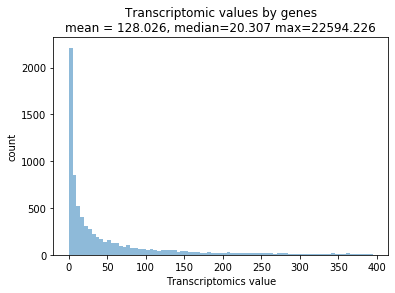

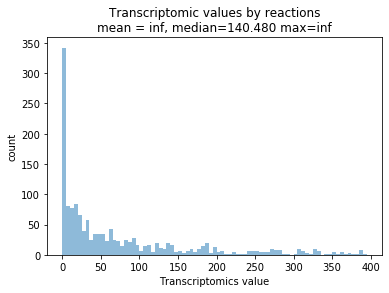

,reaction_id,transcipt_level
0,12DGR120tipp,inf
1,12DGR140tipp,inf
2,12DGR141tipp,inf



Without constraints, flux balance analysis found that 8.402 grams of biomass could be made.

{'EX_h2o_e': inf, 'EX_h_e': inf, 'EX_cl_e': inf, 'EX_pi_e': inf, 'EX_nh4_e': inf, 'EX_fe3_e': inf, 'EX_k_e': inf, 'EX_ca2_e': inf, 'EX_mg2_e': inf, 'EX_mn2_e': inf, 'EX_cobalt2_e': inf, 'EX_zn2_e': inf, 'EX_cu2_e': inf, 'EX_o2_e': inf, 'EX_fe2_e': inf, 'EX_mobd_e': inf, 'EX_so4_e': inf, 'EX_phenol_e': 10.0}

Given the bounds from transcriptmics and a minimum absolute bound of 30, flux balance analysis found that 1576.369 grams of biomass could be made.



In [15]:
sol_WTPR1 = EFlux2test(model, trans_df, 'WT-P-R1', min_bound = 30)

Unused code used for reference

In [ ]:
# def rxn_to_GPR(model, rxn):
#     parallel_gene_sets = set()
#     if rxn.gene_reaction_rule:
#         for parallel_gene_string in rxn.gene_reaction_rule.split(' or '):
#             parallel_gene_string = parallel_gene_string.strip('() ')
#             parallel_gene_list = []
            
#             for gene_name in parallel_gene_string.split(' and '):
#                 gene_name = gene_name.strip('() ')
#                 parallel_gene_list.append(gene_name)
            
#             parallel_gene_sets.add(frozenset(parallel_gene_list))
            
#     return parallel_gene_sets
            
# Orginal code
#     if r.gene_reaction_rule:
#         for x in [x.strip('() ') for x in r.gene_reaction_rule.split(' or ')]:
#             temp.add(frozenset(y.strip('() ') for y in x.split(' and ')))
#         return temp
#     else:
#         return {}
    
# Christina's version
#     if r.gene_reaction_rule:
#         t2 = 0
#         #If a reaction R1 has the GPR of 'A and B', it would be parsed to { {A, B} } in gpr_dict['R1']. Then t for R1 would be sum( [ min(A, B) ] ) = min(A, B).
#         #If a reaction R1 has the GPR of 'A or B', it would be parsed to { {A}, {B} } in gpr_dict['R1']. Then t for R1 would be sum( [ min(A), min(B) ] ) = sum( [A, B] ).
#         #If a reaction R1 has the GPR of '(A and B) or (C and D)', it would be parsed to { {A, B}, {C, D} } in gpr_dict['R1']. Then t for R1 would be sum( [ min(A, B), min(C, D) ] ).
#         for p in gpr_dict[r.id]:
#             xg = []
#             for g in p:
#                 if g in transcriptomics_dict.keys():
#                     print(transcriptomics_dict.get(g))
#                     xg.append(transcriptomics_dict.get(g))
#                 else:
#                     xg.append(np.Inf)
#                 t1 = np.min(xg)
#             t2 = t2 + t1

In [ ]:
# _ = [print(rxn, rxn.upper_bound) for rxn in model.reactions if rxn.upper_bound != 1000] 
# print()
# _ = [print(rxn, rxn.lower_bound) for rxn in model.reactions if ( rxn.lower_bound != -1000 and rxn.lower_bound != 0)] 

In [ ]:
eflux2sol_WTPR1_df = pd.DataFrame(sol_WTPR1.fluxes, columns=['fluxes'])
eflux2sol_WTPR1_df

##### Just linear scale up to solution to see how it compares:

In [ ]:
testscaleeflux2 = eflux2sol_WTPR1_df*(100/1.76124)

In [ ]:
plt.scatter(testscaleeflux2.index,testscaleeflux2.fluxes)
plt.show()

Old efflux code saved as reference material

In [ ]:
# def EFlux2test(model, edd_df, line_name, min_bound = 10):
    # covert transcriptomic df to dictionary of genes and transcript values
#     transcriptomics_dict = {row['Measurement Type']:row['Value'] for _, row in trans_df.iterrows()}
    
#     # plot histogram of transcriptomic measurements
#     plot_histogram(transcriptomics_dict.values(), 'Transcriptomic values')
    
#     # convert model into dictionary of genes and their associated GPRs
#     gpr_dict = model_to_GPR_dictionary(model)
    
#     with model:        
#         # Ensure that medium is correct, and the carbon source is the only limiting substrate
#         medium = {key:np.Inf for (key,value) in model.medium.items()}
#         medium["EX_glc__D_e"] = 0.0
#         medium["EX_phenol_e"] = 1.76124#100.0
#         model.medium = medium
#         print(model.medium) # print the media to prevent inivisible errors
        
#         # calculate maximum biomass yield without constraints
#         model.tolerance = 1e-9
#         unbounded_sol = model.optimize()
#         print(f'\nWithout constraints, flux balance analysis found that {unbounded_sol.objective_value:.3f} grams of biomass could be made.\n')

#         # calculate maximum biomass yield without constraints
#         bounds = []
#         bounded_model = model.copy()
#         with bounded_model:
#             for rxn_id in list(gpr_dict.keys()):
#                 #exclude phenol related rxns from transcript bounds for now:
# #                 if bounded_model.reactions.get_by_id(rxn_id).upper_bound != 1000:
# #                     display('Phenol related rxns excluded from transcript bounds',rxn_id)
# #                     continue
#                 bound = 0
#                 for genes_in_series in gpr_dict[rxn_id]:
#                     bound += min([transcriptomics_dict[gene] if gene in transcriptomics_dict.keys() else 0 for gene in genes_in_series ])

#                 bound = max(bound, min_bound) # min_bound is a parameter of this function
#                 bounds.append(bound)

#                 if bounded_model.reactions.get_by_id(rxn_id).upper_bound > 0:
#                     bounded_model.reactions.get_by_id(rxn_id).upper_bound = bound

#                 elif bounded_model.reactions.get_by_id(rxn_id).lower_bound < 0:
#                     bounded_model.reactions.get_by_id(rxn_id).lower_bound = -1*bound
                    
#         #Alternative to external function:
#         # I think this is more readable than the nested loops. 
#         #         xg = []
#         #         t2 = 0
#         #         for r in model.reactions:
#         #             if r.gene_reaction_rule:
#         #                 t2 = 0
#         #                 #If a reaction R1 has the GPR of 'A and B', it would be parsed to { {A, B} } in gpr_dict['R1']. Then t for R1 would be sum( [ min(A, B) ] ) = min(A, B).
#         #                 #If a reaction R1 has the GPR of 'A or B', it would be parsed to { {A}, {B} } in gpr_dict['R1']. Then t for R1 would be sum( [ min(A), min(B) ] ) = sum( [A, B] ).
#         #                 #If a reaction R1 has the GPR of '(A and B) or (C and D)', it would be parsed to { {A, B}, {C, D} } in gpr_dict['R1']. Then t for R1 would be sum( [ min(A, B), min(C, D) ] ).
#         #                 for p in gpr_dict[r.id]:
#         #                     xg = []
#         #                     for g in p:
#         #                         if g in transcriptomics_dict.keys():
#         #                             print(transcriptomics_dict.get(g))
#         #                             xg.append(transcriptomics_dict.get(g))
#         #                         else:
#         #                             xg.append(np.Inf)
#         #                         t1 = np.min(xg)
#         #                     t2 = t2 + t1

#             # plot histogram of absolute value of bounds inforced
#             plot_histogram(bounds, 'Absolute value of bounds')

#             bounded_sol = bounded_model.optimize()
#             print(f'\nGiven the bounds from transcriptmics and a minimum absolute bound of {min_bound}, flux balance analysis found that {bounded_sol.objective_value:.3f} grams of biomass could be made.\n')

#         # Constrain the biomass to the optimal value
#             print('FBA status', bounded_sol.status)
#             print('FBA solution', bounded_sol.objective_value)
#             display(bounded_model.objective)
#             # Constrain the biomass to the optimal value
#             for rxn_id in bounded_model.reactions:
#                 if rxn_id.objective_coefficient:
#                     rxn_id.lower_bound = bounded_sol.objective_value
#             # minimize the sum of squared flux values
#             bounded_model.objective = bounded_model.problem.Objective(add([rxn_id.flux_expression**2 for rxn_id in bounded_model.reactions]), direction='min')
#             display(bounded_model.problem.Objective)
#             eflux2_sol = bounded_model.optimize()
#             print('EFlux2 status', eflux2_sol.status)
#             print('EFlux2 solution', eflux2_sol.objective_value)
#     return eflux2_sol

#### **Plot solutions: Comparison of SPOT and EFLUX2 solution**

##### **Load 13cdata**

####  **Get 13C MFA measured fluxes for phenol**

In [ ]:
phenol_fluxes = pd.read_csv('../13C_flux_data/13C_phenol_flux_data.csv')
phenol_fluxes.dropna(inplace=True)
print(f'There are {len(phenol_fluxes)} fluxes that can be compared between the MFA and FBA')
phenol_fluxes

### Add Phenol EFLUX2 and SPOT flux values to phenol fluxes dataframe

In [ ]:
def get_flux_value(reaction_id, solution):
    if reaction_id.startswith('reverse_'):
        reaction_id = reaction_id.split('reverse_')[1]
        return -1*solution.fluxes[reaction_id]
    else:
        return solution.fluxes[reaction_id]

In [ ]:
EFLUX2_fluxes = []
#SPOT_fluxes = []
for _, row in phenol_fluxes.iterrows():
    reactions = row['Forward Reactions']
    flux_value_eflux2 = 0
    #flux_value_spot = 0
    for x in [x.strip('() ') for x in reactions.split(' or ')]:
        and_split = [y.strip('() ') for y in x.split(' and ')]
        flux_value_eflux2 += min([get_flux_value(v, testscaleeflux2) for v in and_split])
        #flux_value_spot += min([get_flux_value(v,spotsoldf) for v in and_split])
    EFLUX2_fluxes.append(flux_value_eflux2)
    #SPOT_fluxes.append(flux_value_spot)
    
phenol_fluxes['EFLUX2 Value'] = EFLUX2_fluxes
#phenol_fluxes['SPOT Value'] = SPOT_fluxes
phenol_fluxes

### Plot EFLUX2 vs 13C MFA

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

for pathway in list(set(phenol_fluxes['Pathway'])):
    pathway_df = phenol_fluxes[phenol_fluxes['Pathway'] == pathway]
    
    measured_flux_list = list(pathway_df['Flux'])
    simulated_flux_list = list(pathway_df['EFLUX2 Value'])
    
    ax.scatter(measured_flux_list, simulated_flux_list, label=pathway)


# Dashed line
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, ls="--", c=".3")

plt.title(r'Phenol 13C MFA vs. EFLUX2 Fluxes', fontSize=20)
plt.xlabel(r'13C MFA flux (per 100 mmol of phenol uptake)')
plt.ylabel(r'EFLUX2 flux (per 100 mmol of phenol uptake)')
plt.legend()
plt.show()

-- Stopping here --

In [ ]:
from optlang.symbolics import add
"""
    Provides EFLUX2 predictions as explained in Machado et. al (2014) 
    
        Parameters
        ----------
        model : cobrapy model.
        Transcriptomics : pandas dataframe with transcriptomics data.
        
        Returns
        -------
        eflux2_sol as output from eflux2_model.optimize().
        
"""
#Code only works for GPRs written in disjunctive normal form (DNF). Majority of models have them in DNF but there are some exceptions. 

def EFlux2test(model, df_trans):
    # Convert EDD style dataframe to dictionary
    transcriptomics = {row['Measurement Type']:row['Value'] for _, row in df_trans.iterrows()}
    print(list(transcriptomics.keys())[:5])
    with model:
        
        # Parse GPR into a dict containing isozymes (separated by 'or')
        # Each isozyme has a set of subunits (separated by 'and')
        #'and' and 'or' can occur at the same time, or can occur by itself.
        gpr_dict = dict()
        for r in model.reactions:
            if r.gene_reaction_rule:
                temp = set()
                for x in [x.strip('() ') for x in r.gene_reaction_rule.split(' or ')]:
                    temp.add(frozenset(y.strip('() ') for y in x.split(' and ')))
                gpr_dict[r.id] = temp
                
        # define a variable to hold all bounds
        all_bounds = []
                
        # Set the bounds using the transcriptomics data
        for r in model.reactions:
            if r.gene_reaction_rule:
                
                #If a reaction R1 has the GPR of 'A and B', it would be parsed to { {A, B} } in gpr_dict['R1']. Then t for R1 would be sum( [ min(A, B) ] ) = min(A, B).
                #If a reaction R1 has the GPR of 'A or B', it would be parsed to { {A}, {B} } in gpr_dict['R1']. Then t for R1 would be sum( [ min(A), min(B) ] ) = sum( [A, B] ).
                #If a reaction R1 has the GPR of '(A and B) or (C and D)', it would be parsed to { {A, B}, {C, D} } in gpr_dict['R1']. Then t for R1 would be sum( [ min(A, B), min(C, D) ] ).
                
#                 t = np.sum([np.min([Transcriptomics.loc[g] if g in Transcriptomics.index
#                                     else np.array([np.Inf]) for g in p])
#                             for p in gpr_dict[r.id]])
                t = np.sum([np.min([transcriptomics[g] if g in transcriptomics.keys()
                                    else np.array([np.Inf]) for g in p])
                            for p in gpr_dict[r.id]])
                
                # add bound to the list
                if t != np.Inf:
                    all_bounds.append(t)
                
                # Enforce transcriptomic bound
                if r.lower_bound < 0.0:
                    r.lower_bound = -t
                if r.upper_bound > 0.0:
                    r.upper_bound = t
            else:
                #When there is no GPR, the arbitrary bounds are removed. 
                #Common arbitrary bound value of 1000 for E.coli, might be different depending on the model, e.g., 99999.0 for iMM904 yeast model in BiGG
                if r.lower_bound <= -1000.0:
                    r.lower_bound = -np.Inf
                if r.upper_bound >= 1000.0:
                    r.upper_bound = np.Inf
              
        # These statements can help with scaling bounds to reasonable limits
        print(all_bounds[:20])
        print(len(all_bounds))
        print(f'The average bound was {sum(all_bounds) / len(all_bounds)}')
        print(f'The max bound was {max(all_bounds)}')
        
        # print the media to prevent inivisible errors
        display(model.medium)
        
        # solve FBA with transcriptomic enforced bounds to calculate the maximum biomass
        model.tolerance = 1e-9
        fba_sol = model.optimize()
        
        print(f'The FBA solution was {fba_sol.status}.' )
        print(f'Given the bounds from transcriptomics, flux balance analysis found that{fba_sol.objective_value:.3f} grams of biomass could be made.\n')
        
        # Constrain the biomass to the optimal value
        for r in model.reactions:
            if r.objective_coefficient:
                r.lower_bound = fba_sol.objective_value
                
        # minimize the sum of squared flux values
        model.objective = model.problem.Objective(add([r.flux_expression**2 for r in model.reactions]), direction='min')
        eflux2_sol = model.optimize()
        
        print(f'The EFLUX2 solution was {eflux2_sol.status}.' )
        print(f'The minimum sum of squared fluxes to make {fba_sol.objective_value:.3f} grams of biomass given the bounds from transcriptomics is {eflux2_sol.objective_value:.1f}.\n')

    return eflux2_sol

In [ ]:
# eflux2sol_WTPR1, spotsol_WTPR1 = eflux2spotpred(model, df_Trans2, 'WT-P-R1', 'phenol', 100)
# eflux2sol_WTPR2, spotsol_WTPR2 = eflux2spotpred(model, df_Trans2, 'WT-P-R2', 'phenol', 100)
# eflux2sol_WTPR3, spotsol_WTPR3 = eflux2spotpred(model, df_Trans2, 'WT-P-R3', 'phenol', 100)

In [ ]:
# eflux2sol_WTPR1.fluxes

In [ ]:
# eflux2sol_WTPR1_df = pd.DataFrame(eflux2sol_WTPR1.fluxes, columns=['fluxes'])
# eflux2sol_WTPR2_df = pd.DataFrame(eflux2sol_WTPR2.fluxes, columns=['fluxes'])
# eflux2sol_WTPR3_df = pd.DataFrame(eflux2sol_WTPR3.fluxes, columns=['fluxes'])
# eflux2sol_WTPR = pd.concat([eflux2sol_WTPR1_df, eflux2sol_WTPR2_df, eflux2sol_WTPR3_df], axis=1)
# eflux2sol_WTPR.rename(columns = {'fluxes':'R1', 'fluxes':'R2','fluxes':'R3'}, inplace=False)
# eflux2sol_WTPR.mean(axis=1)
# eflux2sol_WTPR.std(axis=1)


In [ ]:
# eflux2sol_WTPR

##### **Modularized way**

In [ ]:
#Function for EFLUX2 and SPOT Predictions:
def eflux2spotpred(model, transcript_df, line_name, substrate, sub_uptake_rate):    
    with model:
        
        # This is to prevent medium components other than glucose from being growth limitations
        medium = model.medium
        medium = {key:1000 for (key,value) in model.medium.items()}
    
        if substrate == 'phenol':
            model.objective = 'Growth_Phenol'
            model.reactions.get_by_id('Growth_Glucose').upper_bound = 0
            model.reactions.get_by_id('Growth_Glucose').lower_bound = 0
            medium["EX_glc__D_e"] = 0.0
            medium["EX_phenol_e"] = sub_uptake_rate
            
        elif substrate == 'glucose':
            model.objective = 'Growth_Glucose'
            model.reactions.get_by_id('Growth_Phenol').upper_bound = 0
            model.reactions.get_by_id('Growth_Phenol').lower_bound = 0
            medium["EX_glc__D_e"] = sub_uptake_rate
            medium["EX_phenol_e"] = 0.0
            
        else:
            print('Unknown substrate: Please choose among phenol and glucose')
            
        model.medium = medium
        
        eflux2sol = EFlux2test(model, transcript_df[transcript_df['Line Name'] == line_name])
        spotsol = SPOT(model, transcript_df[transcript_df['Line Name'] == line_name])
    return eflux2sol, spotsol

In [ ]:
eflux2sol_WTPR1, spotsol_WTPR1 = eflux2spotpred(model, df_trans, 'WT-P-R1', 'phenol', 100)

In [ ]:
#display(eflux2sol_WTPR1.fluxes['Growth_Phenol'])

In [ ]:
#spotsol_WTPR1df =pd.DataFrame(spotsol_WTPR1, columns=['fluxes'])
#spotsol_WTPR1df

In [ ]:
#Function for predictions for three replicates and averaging the solutions and calculating the standard deviation:
def eflux2spotpredthreereps(model, transcript_df, line_name1, line_name2, line_name3, substrate, sub_uptake_rate):
    
    #call prediction functions for individual EFLUX2 predictions for all 3 replicates:
    eflux2sol_R1, spotsol_R1 = eflux2spotpred(model, transcript_df, line_name1, substrate, sub_uptake_rate)
    eflux2sol_R2, spotsol_R2 = eflux2spotpred(model, transcript_df, line_name2, substrate, sub_uptake_rate)
    eflux2sol_R3, spotsol_R3 = eflux2spotpred(model, transcript_df, line_name3, substrate, sub_uptake_rate)
    
    #EFLUX2 calculations:
    eflux2sol_R1_df = pd.DataFrame(eflux2sol_R1.fluxes, columns=['fluxes'])
    eflux2sol_R2_df = pd.DataFrame(eflux2sol_R2.fluxes, columns=['fluxes'])
    eflux2sol_R3_df = pd.DataFrame(eflux2sol_R3.fluxes, columns=['fluxes'])
    eflux2sol_all = pd.concat([eflux2sol_R1_df, eflux2sol_R2_df, eflux2sol_R3_df], axis=1)

    eflux2sol = pd.DataFrame(eflux2sol_all.mean(axis=1), columns=['fluxes'])
    eflux2sol_std = eflux2sol_all.std(axis=1)
    
    #SPOT calculations:
    spotsol_R1_df = pd.DataFrame(spotsol_R1, columns=['fluxes'])
    spotsol_R2_df = pd.DataFrame(spotsol_R2, columns=['fluxes'])
    spotsol_R3_df = pd.DataFrame(spotsol_R3, columns=['fluxes'])
    spotsol_all = pd.concat([spotsol_R1_df, spotsol_R2_df, spotsol_R3_df], axis=1)
    
    spotsol = spotsol_all.mean(axis=1)
    spotsol_std = spotsol_all.std(axis=1)
    
    return eflux2sol, eflux2sol_std, spotsol, spotsol_std

In [ ]:
eflux2sol, eflux2sol_std, spotsol, spotsol_std = eflux2spotpredthreereps(model, df_trans, 'WT-P-R1', 'WT-P-R2','WT-P-R3', 'phenol', 100)
#eflux2sol, eflux2sol_std = eflux2spotpredthreereps(model, df_Trans2, 'WT-P-R1', 'WT-P-R2','WT-P-R3', 'phenol', 100)

In [ ]:
eflux2soldf = pd.DataFrame(eflux2sol, columns=['fluxes'])
eflux2solstddf = pd.DataFrame(eflux2sol_std, columns=['fluxes'])
spotsoldf = pd.DataFrame(spotsol, columns=['fluxes'])
spotsolstddf = pd.DataFrame(spotsol_std, columns=['fluxes'])

#### **Plot solutions: Comparison of SPOT and EFLUX2 solution**

##### **Load 13cdata**

####  **Get 13C MFA measured fluxes for phenol**

In [ ]:
phenol_fluxes = pd.read_csv('../13C_flux_data/13C_phenol_flux_data.csv')
phenol_fluxes.dropna(inplace=True)
print(f'There are {len(phenol_fluxes)} fluxes that can be compared between the MFA and FBA')
phenol_fluxes

### Add Phenol EFLUX2 and SPOT flux values to phenol fluxes dataframe

In [ ]:
def get_flux_value(reaction_id, solution):
    if reaction_id.startswith('reverse_'):
        reaction_id = reaction_id.split('reverse_')[1]
        return -1*solution.fluxes[reaction_id]
    else:
        return solution.fluxes[reaction_id]

In [ ]:
EFLUX2_fluxes = []
SPOT_fluxes = []
for _, row in phenol_fluxes.iterrows():
    reactions = row['Forward Reactions']
    flux_value_eflux2 = 0
    flux_value_spot = 0
    for x in [x.strip('() ') for x in reactions.split(' or ')]:
        and_split = [y.strip('() ') for y in x.split(' and ')]
        flux_value_eflux2 += min([get_flux_value(v, eflux2soldf) for v in and_split])
        flux_value_spot += min([get_flux_value(v,spotsoldf) for v in and_split])
    EFLUX2_fluxes.append(flux_value_eflux2)
    SPOT_fluxes.append(flux_value_spot)
    
phenol_fluxes['EFLUX2 Value'] = EFLUX2_fluxes
phenol_fluxes['SPOT Value'] = SPOT_fluxes
phenol_fluxes

### Plot EFLUX2 vs 13C MFA

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

for pathway in list(set(phenol_fluxes['Pathway'])):
    pathway_df = phenol_fluxes[phenol_fluxes['Pathway'] == pathway]
    
    measured_flux_list = list(pathway_df['Flux'])
    simulated_flux_list = list(pathway_df['EFLUX2 Value'])
    
    ax.scatter(measured_flux_list, simulated_flux_list, label=pathway)


# Dashed line
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, ls="--", c=".3")

plt.title(r'Phenol 13C MFA vs. EFLUX2 Fluxes', fontSize=20)
plt.xlabel(r'13C MFA flux (per 100 mmol of phenol uptake)')
plt.ylabel(r'EFLUX2 flux (per 100 mmol of phenol uptake)')
plt.legend()
plt.show()

### Plot SPOT vs 13C MFA

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

for pathway in list(set(phenol_fluxes['Pathway'])):
    pathway_df = phenol_fluxes[phenol_fluxes['Pathway'] == pathway]
    
    measured_flux_list = list(pathway_df['Flux'])
    simulatedspot_flux_list = list(pathway_df['SPOT Value'])
    
    ax.scatter(measured_flux_list, simulatedspot_flux_list, label=pathway)


# Dashed line
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, ls="--", c=".3")

plt.title(r'Phenol 13C MFA vs. SPOT Fluxes', fontSize=20)
plt.xlabel(r'13C MFA flux (per 100 mmol of phenol uptake)')
plt.ylabel(r'SPOT flux (per 100 mmol of phenol uptake)')
plt.legend()
plt.show()

In [ ]:
rxns = [r.id for r in model.reactions]
# #EFlux2_fluxdict = dict(zip(rxns,EFlux2_min.solution.get_values()))
# EFlux2_fluxdict = dict(zip(rxns,eflux2solfluxes.to_numpy()))#replace previous .get_values()
# SPOT_fluxdict = dict(zip(rxns,spotsolWTPR1.to_numpy()))#replace previous .get_values()
# #display(SPOT_fluxdict)

In [ ]:
#Scatterplot of solutions
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm

def maefunc(y_predict, y_actual):
    """Mean Absolute Error.
    Multioutput case included."""

    if y_actual.ndim == 1:
        return np.mean(np.abs([y_a - y_p for y_a, y_p in zip(y_actual, y_predict)]))
    else:
        return [
            np.mean(
                np.abs([y_a - y_p for y_a, y_p in zip(y_actual[:, i], y_predict[:, i])])
            )
            for i in range(y_actual.shape[1])
        ]
    
def scatterplotcompare(observed, predicted, labels, strtitle):
    fig, ax = plt.subplots(figsize=(8, 8))
    #res = stats.linregress(observed.to_numpy().astype(float), predicted.to_numpy())
    #print(res.rvalue**2)
    lims = [
                np.min([observed, predicted]),  # min of both axes
                np.max([observed, predicted]),  # max of both axes
            ]
    ax.set_xlim(lims)
    #ax.plot([0.0, 0.2], [0.0, 0.2], 'k',  c='0.55')
    # Plot Diagonal Dashed Line
    ax.plot(lims, lims, ls="--", color=".8", zorder=0)
    for i in range(0, len(observed)):
        ax.scatter(observed[i], predicted[i])
        #ax.annotate(str(labels[i]),(observed[i],predicted[i]))
    #ax.annotate("r-squared = {:.3f}".format(round(r2_score(observed, predicted))), (0, 1))
    #plt.plot(observed, res.intercept + res.slope*observed, 'k', label='fitted line')
    rss = np.sum((predicted - observed) ** 2)
    tss = np.sum((predicted - predicted.mean()) ** 2)
    r2_1 = np.round(1 - rss / tss,2)
    #display(r2_1)
    #r2 = round(r2_score(observed, predicted),2)
    mse = np.round(1/len(observed) * rss,2) 
    rmse = np.round(np.sqrt(1/len(observed) * rss),2)
    #display(rmse)
    #display(r2_score(observed, predicted))
    mae_score = np.round(maefunc(observed, predicted),2)
    plt.xlabel(r'EFLUX2')#Observed growth rates [$mmol/gDW/hr$]')
    plt.ylabel(r'SPOT')#Predicted growth rates [$mmol/gDW/hr$]')
    #plt.title(r'Growth rates: Observed vs. Predicted ('+strtitle+'), \n' + f"$R^2$={r2_1}, MAE={mae_score}, MSE = {mse}, RMSE={rmse}", fontsize=18)
    plt.title(r'EFLUX2 vs. SPOT ('+strtitle+'), \n' + f"$R^2$={r2_1}, MAE={mae_score}, MSE = {mse}, RMSE={rmse}", fontsize=18)
    plt.show()

In [ ]:
scatterplotcompare(eflux2soldf.to_numpy(), spotsoldf.to_numpy(), labels='', strtitle='')

In [ ]:
scatterplotcompare(eflux2soldf.loc['Growth_Phenol',:], spotsoldf.loc['Growth_Phenol',:], labels='Growth', strtitle='')

In [ ]:
from optlang.symbolics import add
"""
    Provides EFLUX2 predictions as explained in Machado et. al (2014) 
    
        Parameters
        ----------
        model : cobrapy model.
        Transcriptomics : pandas dataframe with transcriptomics data.
        
        Returns
        -------
        eflux2_sol as output from eflux2_model.optimize().
        
"""
#Code only works for GPRs written in disjunctive normal form (DNF). Majority of models have them in DNF but there are some exceptions. 

def EFlux2test(model, Transcriptomics):
    #with model as eflux2_model:
    eflux2_model = model.copy()
    # Parse GPR into a dict containing isozymes (separated by 'or')
    # Each isozyme has a set of subunits (separated by 'and')
    #'and' and 'or' can occur at the same time, or can occur by itself.
    gpr_dict = dict()
    for r in eflux2_model.reactions:
        if r.gene_reaction_rule:
            temp = set()
            for x in [x.strip('() ') for x in r.gene_reaction_rule.split(' or ')]:
                temp.add(frozenset(y.strip('() ') for y in x.split(' and ')))
            gpr_dict[r.id] = temp
    #display(gpr_dict)
    # Set the bounds using the transcriptomics data
    for r in eflux2_model.reactions:
        t2=0
        if r.gene_reaction_rule:
            #If a reaction R1 has the GPR of 'A and B', it would be parsed to { {A, B} } in gpr_dict['R1']. Then t for R1 would be sum( [ min(A, B) ] ) = min(A, B).
            #If a reaction R1 has the GPR of 'A or B', it would be parsed to { {A}, {B} } in gpr_dict['R1']. Then t for R1 would be sum( [ min(A), min(B) ] ) = sum( [A, B] ).
            #If a reaction R1 has the GPR of '(A and B) or (C and D)', it would be parsed to { {A, B}, {C, D} } in gpr_dict['R1']. Then t for R1 would be sum( [ min(A, B), min(C, D) ] ).
            t = np.sum([np.min([Transcriptomics.loc[g].values if g in Transcriptomics.index
                                else np.array([np.Inf]) for g in p])
                        for p in gpr_dict[r.id]])
            for p in gpr_dict[r.id]:
                xg=[]
                for g in p:
                    if g in Transcriptomics.index:
                        xg.append(Transcriptomics.loc[g].values)
                    else:
                        xg.append(np.array([np.Inf]))
                    t2=np.min(xg)
                t2+=t2
            if t2!=t:
                display('difference',t2, t)
            if t != np.inf:
                display(t)
            if r.lower_bound < 0.0:
                r.lower_bound = -t
            else:
                pass
            if r.upper_bound > 0.0:
                r.upper_bound = t
            else:
                pass
        else:
            #When there is no GPR, the arbitrary bounds are removed. 
            #Common arbitrary bound value of 1000 for E.coli, might be different depending on the model, e.g., 99999.0 for iMM904 yeast model in BiGG
            if r.lower_bound < -99999:
                r.lower_bound = -np.Inf
            if r.upper_bound > 99999:
                r.upper_bound = np.Inf 
            if r.lower_bound >= 0:
                r.lower_bound = 0
            if r.upper_bound <= 0:
                r.upper_bound = 0

#             if r.lower_bound < 0.0 and r.lower_bound > -1000.0:
#                 print(r.id, r.lower_bound, r.upper_bound)
#                 r.lower_bound = -1000.0
#             elif r.lower_bound > 0.0:
#                 print(r.id, r.lower_bound, r.upper_bound)
#                 r.lower_bound = 0.0
#             if r.upper_bound > 0.0 and r.upper_bound < 1000.0:
#                 print(r.id, r.lower_bound, r.upper_bound)
#                 r.upper_bound = 1000.0
#             elif r.upper_bound < 0.0:
#                 print(r.id, r.lower_bound, r.upper_bound)
#                 r.upper_bound = 0.0
#             if r.lower_bound == -1000.0:
#                 r.lower_bound = -np.Inf
#             if r.upper_bound == 1000.0:
#                 r.upper_bound = np.Inf

#             if r.lower_bound < 0.0:
#                 r.lower_bound = -np.Inf
#             elif r.lower_bound >= 0.0:
#                 r.lower_bound = 0.0
#             elif r.upper_bound > 0.0:
#                 r.upper_bound = np.Inf
#             elif r.upper_bound <= 0.0:
                r.upper_bound = 0.0
#                 if r=='Phenol_e':
#                     display(r)
#                     r.lower_bound = -100
#                     r.upper_bound = 0
    display(eflux2_model.medium)
    # solve FBA to calculate the maximum biomass
    eflux2_model.tolerance = 1e-9
    fba_sol = eflux2_model.optimize()
    print('FBA status', fba_sol.status)
    print('FBA solution', fba_sol.objective_value)
    display(eflux2_model.objective)
    # Constrain the biomass to the optimal value
    for r in eflux2_model.reactions:
        if r.objective_coefficient:
            r.lower_bound = fba_sol.objective_value
    # minimize the sum of squared flux values
    eflux2_model.objective = eflux2_model.problem.Objective(add([r.flux_expression**2 for r in eflux2_model.reactions]), direction='min')
    display(eflux2_model.problem.Objective)
    eflux2_sol = eflux2_model.optimize()
    print('EFlux2 status', eflux2_sol.status)
    print('EFlux2 solution', eflux2_sol.objective_value)
    # return eflux2 solution
    return eflux2_sol